In [1]:
import tweepy
import re
import csv
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from datetime import datetime

In [43]:
# Authenticate to Twitter
consumer_key = '4Ft8G39Py6aBoJCO0BSv8sgd2'
consumer_secret = '6ijVxle8eCqFSnGzP6KejCeZR6skWJguoufj6YFbDR5pVZrQMX'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAACHAlQEAAAAAJprTqqhmpTWpWHPPzwnt%2FIoBWpw%3DAs7igyoLU5tA2v8pian9sWggiMGFDJjwwko5cqNsWvJBMjXGTE'
access_token ='937601962077573120-U1NOzPdCshnXsTFjUG7zOyTq3LObFVW'
access_token_secret = 'YnO3eV6ENps3hLrSTH9o7Yl5wKpXDIwgS95pqCfumDBAy'

# Authorisation
auth_user = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
auth_app = tweepy.AppAuthHandler(consumer_key, consumer_secret)

# Create API object
api_user = tweepy.API(auth_user, wait_on_rate_limit = True)
api_app = tweepy.API(auth_app, wait_on_rate_limit = True)

In [46]:
# check the rate limit status for the statuses/user_timeline endpoint
rate_limit_status = api_app.rate_limit_status()

# check the remaining number of requests for the statuses/user_timeline endpoint
remaining = rate_limit_status['resources']['statuses']['/statuses/user_timeline']['remaining']

# check the time at which the rate limit will reset for the statuses/user_timeline endpoint
reset_time = rate_limit_status['resources']['statuses']['/statuses/user_timeline']['reset']

print(f"Remaining requests: {remaining}")
print(f"Rate limit reset time: {reset_time}")
print(f"Rate limit reset date UTC:", datetime.fromtimestamp(reset_time).strftime("%Y-%m-%d %H:%M:%S"))

Remaining requests: 1500
Rate limit reset time: 1675010996
Rate limit reset date UTC: 2023-01-29 17:49:56


In [ ]:
# Specify the Twitter account you want to check
username = 'CryptoTubylec'

# Count total number of tweets account has published to retrieve from
user = api_app.get_user(screen_name=username)
max_user_tweets = user.statuses_count
print('Max user tweets:', max_user_tweets)

# List for storing all tweets
all_tweets = []

# first tweet id needed to start iteration over tweets with max_id param from user_timeline
oldest_tweet_id = api_app.user_timeline(screen_name=username, count=1)[0].id

while len(all_tweets) < max_user_tweets:
        
    # max tweets to get from API is 200
    new_tweets = api_app.user_timeline(screen_name=username, count=200, max_id=oldest_tweet_id)
        
    all_tweets.extend(new_tweets)
        
    oldest_tweet_id = all_tweets[-1].id

# Check if all tweets retrieved
print(len(all_tweets)==max_user_tweets)

In [87]:
with open(f'../data/processed/{username}-tweets.json', "w") as file:
    tweets_json = [tweet._json for tweet in all_tweets]
    json.dump(tweets_json, file)
        
#tweets_from_json = pd.read_json(f'../data/processed/{username}-tweetsa.json')
#tweets_from_json[['created_at','id','text','entities','retweet_count','favorite_count']]

TypeError: open() argument 'mode' must be str, not set

In [84]:
datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

'2023-01-29-18:34:41'

In [ ]:
def make_dataset_from_tweets_json(tweets_from_json):
    

In [9]:
dollar_words = []

for tweet in all_tweets:
    # Extract the dollar words from the tweet text
    dollar_words_in_tweet = re.findall(r'\$\w+', tweet.text)
    at_words_in_tweet = re.findall(r'\@\w+', tweet.text)

    
    # Extract the datetime of the tweet
    datetime = tweet.created_at
    
    # Iterate over the dollar words
    for dollar_word in dollar_words_in_tweet:
        # Append the dollar word and datetime to the list
        dollar_words.append((dollar_word, datetime, tweet.id))
        
    # Iterate over the @ references
    for at_word in at_words_in_tweet:
        # Append the dollar word and datetime to the list
        dollar_words.append((dollar_word, datetime, tweet.id))

AttributeError: 'str' object has no attribute 'text'

In [321]:
unique_tokens_list = set([d[0] for d in dollar_words]) # lista zbyt dluga, trzeba recznie, lub sortowac po dacie

unique = list(dict.fromkeys([d[0] for d in dollar_words])) # lista poszeregowana czasowo

#sprawdz czy sie zgadzaja obie listy

len(unique_tokens_list)==len(unique)

In [301]:
# collect only CAW tweets
def token_tweets():
token_name = 'CAW'
caw = []        
for i in dollar_words:
    if token_name in i[0]:
        #print(i[0], " - ", i[1].strftime("%Y-%m-%d %H:%M"),'UTC')
        caw.append(i[1].strftime("%Y-%m-%d %H:%M"))

In [308]:
# This function finds token name (coin_id) based on symbol given 
def find_token_symbol(token_name):
    
    # Get table of coins with maaping to symbols from coingecko
    response_list = requests.get(f'https://api.coingecko.com/api/v3/coins/list')
    coins_list = json.loads(response_list.text)
    
    # Get coin name based on symbol given
    for c in coins_list:
        if c['symbol']==token_name.lower():
            return(c['id'])

#find_token_symbol('CAW')

'arbinu'

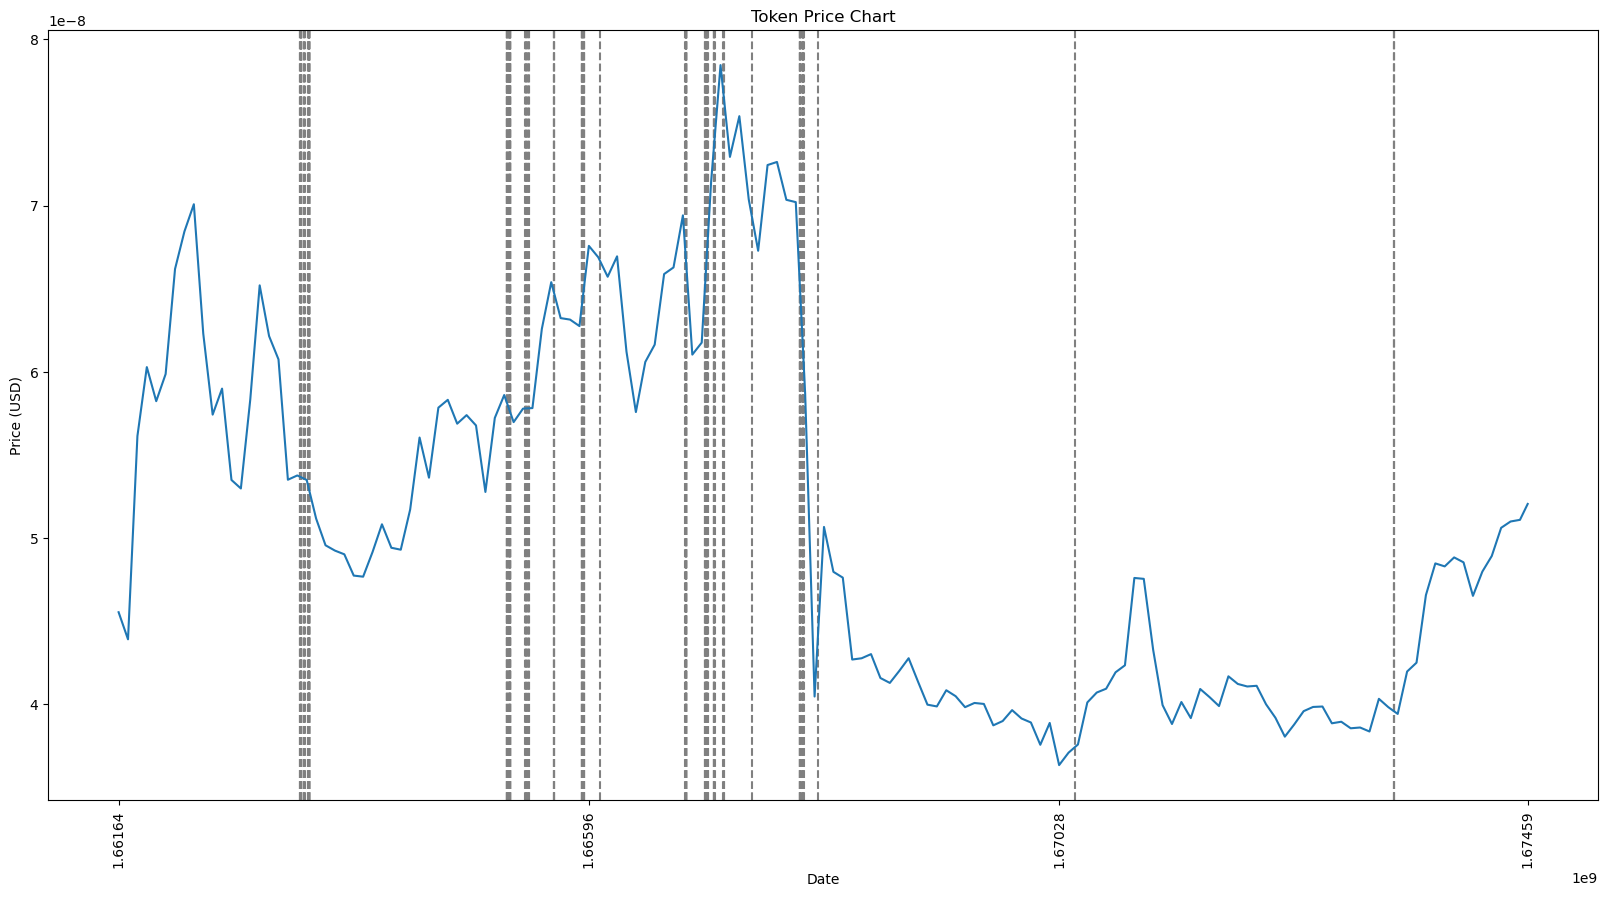

In [283]:
token_name = find_token_symbol('CAW') # function returns token name based on symbol CAW

# Make the GET request to the CoinGecko API
response = requests.get(f'https://api.coingecko.com/api/v3/coins/{token_name}/market_chart?vs_currency=usd&days=150')

# Parse the JSON data from the API response
data = json.loads(response.text)

# Extract the price data from the API response
prices = [point[1] for point in data['prices']]
dates = [int(point[0]/1000).strftime("%Y-%m-%d %H:%M") for point in data['prices']]
tweet_dates = [word[1] for word in caw]


# Create a line chart of the price data
plt.figure(figsize=(20,10))

for c in caw:
    plt.axvline(c, color='gray', linestyle='--')

plt.plot(dates, prices)
plt.xticks(dates[::50])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Token Price Chart')

# Show the chart
plt.show()

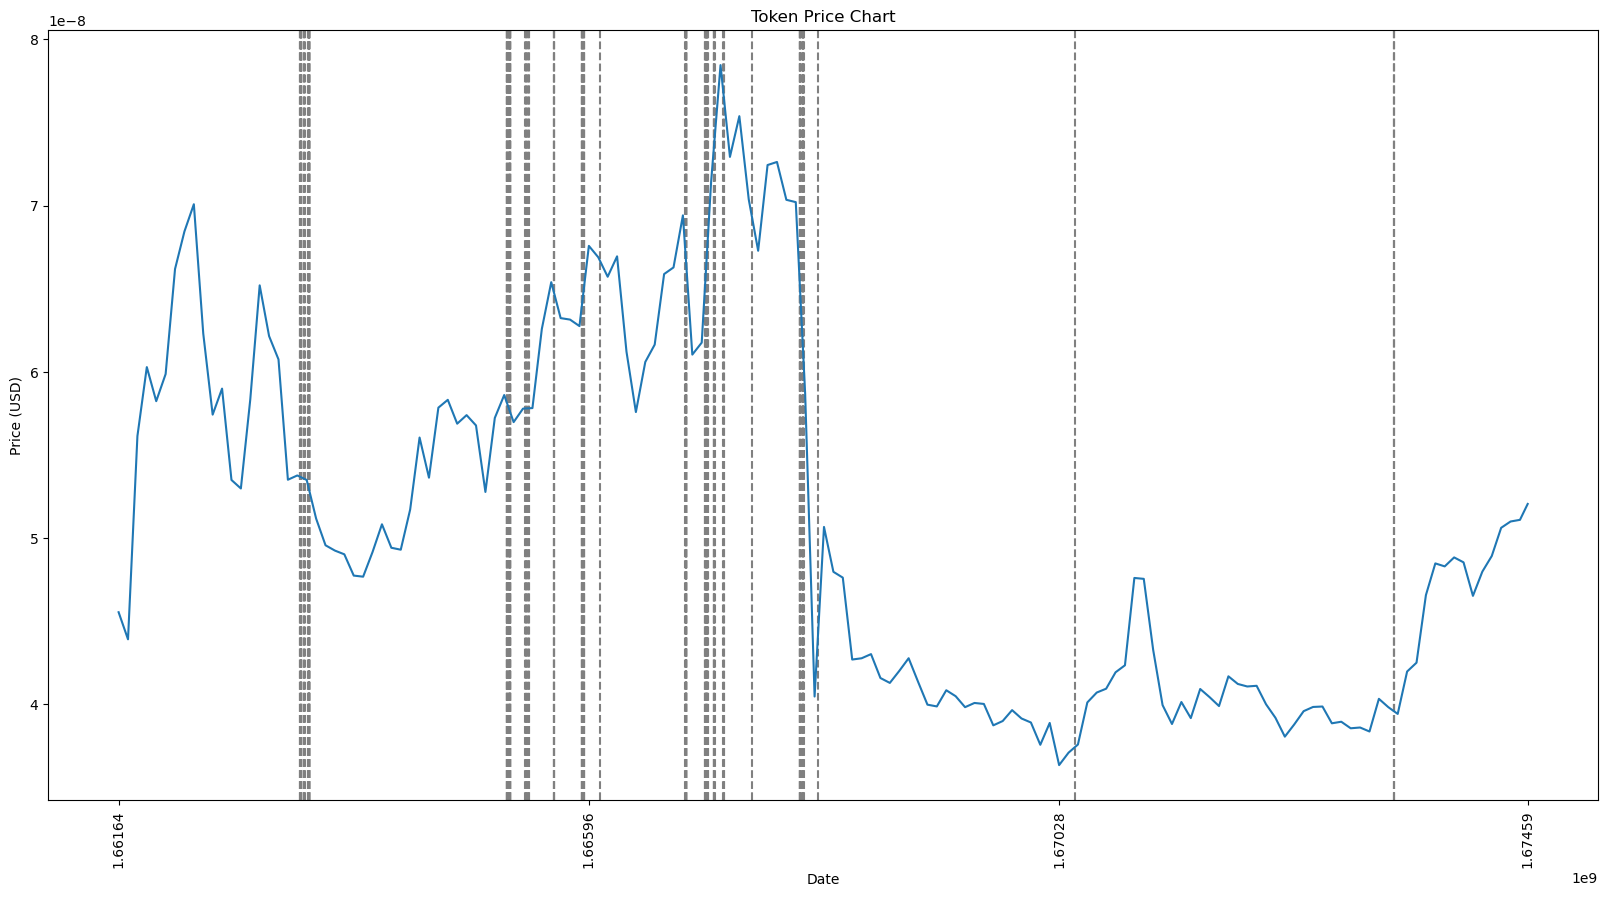

In [287]:
token_name = 'a-hunters-dream' #CAW

# Make the GET request to the CoinGecko API
response = requests.get(f'https://api.coingecko.com/api/v3/coins/{token_name}/market_chart?vs_currency=usd&days=150')

# Parse the JSON data from the API response
data = json.loads(response.text)

# Extract the price data from the API response
prices = [point[1] for point in data['prices']]
dates = [int(point[0]/1000) for point in data['prices']]
tweet_dates = [word[1] for word in caw]




# Create a line chart of the price data
plt.figure(figsize=(20,10))

# Plot vertical line for every occurence of token name in a tweet using date
for c in caw:
    plt.axvline(datetime.strptime(c, "%Y-%m-%d %H:%M").timestamp(), color='gray', linestyle='--')

plt.plot(dates, prices)
plt.xticks(dates[::50]) # plot every 50 dates for visiblity
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Token Price Chart')

# Show the chart
plt.show()

In [57]:
# Specify the Twitter account you want to check
username = 'CryptoTubylec'

# Count total number of tweets account has published to retrieve from
user = api.get_user(screen_name=username)
max_user_tweets = user.statuses_count

# Get the user's tweets with count 200 (max tweets that can be retrieved with API limit, )
tweets = api.user_timeline(screen_name=username, count=200)

# Initialize an empty list to store the dollar words
dollar_words = []

tweets_collection = []

# Iterate over the tweets
for tweet in tweets:
    # Extract the dollar words from the tweet text
    dollar_words_in_tweet = re.findall(r'\$\w+', tweet.text)
    
    # Extract the datetime of the tweet
    datetime = tweet.created_at
    
    tweet_identification = tweet.id
    
    tweet_content = tweet.text
    
    tweet_url = tweet.entities['urls'][0]['expanded_url']
    
    # Iterate over the dollar words
    for dollar_word in dollar_words_in_tweet:
        # Append the dollar word and datetime to the list
        dollar_words.append((dollar_word, datetime))
        
    tweets_collection.append([tweet_identification, datetime, dollar_words_in_tweet, tweet_content, tweet_url])

# Print the list of dollar words and datetime
#print(dollar_words[1])